In [1025]:
# I/O
# ---
import os
import pandas as pd

CWD = os.getcwd()
DIR = '/WikiPhrases'
load_file = 'wiki_phrases.csv' #  'wiki_phrases.json'
save_file = 'wiki_phrases_clean.csv'
load_path =  CWD + os.path.join(DIR, load_file)
save_path =  CWD + os.path.join(DIR, save_file)

print("CWD      : {}".format(CWD))
print("Load path: {}".format(load_path))
print("Save path: {}".format(save_path))

wiki_old = pd.read_csv(load_path)

wiki_old.head(4)
#wiki_new.to_csv(save_path, index=False)

CWD      : /home/l/AnacondaProjects/NameGen
Load path: /home/l/AnacondaProjects/NameGen/WikiPhrases/wiki_phrases.csv
Save path: /home/l/AnacondaProjects/NameGen/WikiPhrases/wiki_phrases_clean.csv


,Phrases,Category,NumWords
0,A priori and a posteriori,Biases,5
1,Abductive reasoning,Biases,2
2,Abusive fallacy,Biases,2
3,Abusive power and control,Biases,4


In [1026]:
# Exploration of specific categories of words
# -------------------------------------------
from itertools import chain, combinations
from operator import itemgetter

# Pick categories
words = 'Phrases'
CATEGORIES = ['Statistics']
wiki_temp = wiki_old.loc[wiki_old['Category'].isin(CATEGORIES)]
the_phrases = wiki_temp.Phrases


# Set condition categories
wiki_temp.loc[:,('NumWords')] = the_phrases.str.split().str.len()
wiki_temp.loc[:,('Alpha')] = the_phrases.str.replace(" ","").str.isalpha()
wiki_temp.loc[:,('Uppercase')] = the_phrases.str.isupper()

# Set conditions dict:
conditions = {}
conditions["NumWords"] = (wiki_temp["NumWords"] == 1)
conditions["Alpha"] = (wiki_temp["Alpha"] == True)
conditions["Uppercase"] = (wiki_temp["Uppercase"] == True)
cs = conditions.copy() # shortcut


# Display occurences for any amount of conditions.
# Pure fun
def fast_insight(the_phrases, cond, df, head):
    
    # Get all combinations of conditions
    def get_combinations(iterable):
        s = list(iterable)
        return [cond for cond in chain.from_iterable(combinations(s, r) for r in range(len(s)+1)) if cond]
    cond_combinations = get_combinations(cond.keys())
    
    # Get nr of occurences for all combination of conditions
    def proc(nr): 
        return round((nr/l)*100, 2)
    l = len(the_phrases)
    insights = []
    for c in cond_combinations:
        nr_of_conditions = len(c)
        cats = ",".join([cond for cond in c])
        conds = ["cond[c[{}]]".format(i) for i in range(len(c))]
        conds_string = " & ".join(conds)
        nr = eval("len(the_phrases[{}])".format(conds_string))
        string = "{:30} {: 6}{:10}".format(cats, nr, proc(nr))
        insights.append((string,nr))

    # Display
    print("All category words phrases:      {}\n".format(l))
    for insight in sorted(insights,key=itemgetter(1))[::-1]:
        print(insight[0])
    print('\nTo get a series use as (fg.):\nthe_phrases[cs["NumWords"] & cs["Alpha"]]')
    display(df.head(head))

# fast_insight(the_phrases, cond=cs, df=wiki_temp, head=3)

/home/l/.conda/envs/spacy/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/l/.conda/envs/spacy/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [1027]:
fast_insight(the_phrases, cond=cs, df=wiki_temp, head=3)
# the_phrases[cs["Alpha"] & cs["Uppercase"]]
# the_phrases[cs["Alpha"] & cs["Uppercase"]]
# the_phrases[~ cs["Alpha"]]
# wiki_temp[wiki_temp['Phrases'].str.contains('-')]
# wiki_new.Phrases.str.count('-').sum()

All category words phrases:      3562

Alpha                            2820     79.17
NumWords                          478     13.42
NumWords,Alpha                    395     11.09
Uppercase                          41      1.15
NumWords,Uppercase                 40      1.12
Alpha,Uppercase                    36      1.01
NumWords,Alpha,Uppercase           35      0.98

To get a series use as (fg.):
the_phrases[cs["NumWords"] & cs["Alpha"]]


,Phrases,Category,NumWords,Alpha,Uppercase
1932,1.96,Statistics,1,False,False
1933,100-year flood,Statistics,2,False,False
1934,2SLS,Statistics,1,False,True


In [1028]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [1029]:
# Get spaCy tags for phrases

def get_Spacy_tags_for(phrases_column):
    lemma = []
    pos = []
    tag = []
    ent_type = []
    for doc in nlp.pipe(phrases_column.astype('unicode').values, batch_size=50,
                            n_threads=4):
        if doc.is_parsed:
            lemma_seq = " ".join([n.lemma_ for n in doc])
            tag_seq = " ".join([n.tag_ for n in doc])
            pos_seq = " ".join([n.pos_ for n in doc])
            ent_seq = " ".join([n.ent_type_ for n in doc])

            lemma.append(lemma_seq)
            pos.append(tag_seq)
            tag.append(pos_seq)
            ent_type.append(ent_seq)
        else:
            lemma.append(None)
            pos.append(None)
            tag.append(None)
            ent_type.append(None)
    return lemma, pos, tag, ent_type


# 1. Load data
wiki_old = pd.read_csv(load_path)

# 2. Prepare series for getting tags: (dash-splited and not)
wiki_old['splited'] = wiki_old['Phrases'].str.split('–').str.join(" ").str.split('-').str.join(" ").map(lambda x: x.strip())
phrases_column1 = wiki_old['Phrases']
phrases_column2 = wiki_old['splited']

# 3a. Run without splitting words on dash
lemma, pos, tag, ent_type = get_Spacy_tags_for(phrases_column1)
# 3b. Run with splitting words on dash
s_lemma, s_pos, s_tag, s_ent_type =  get_Spacy_tags_for(phrases_column2)

# 4. Launch new df
wiki_new = pd.DataFrame(lemma, columns=['_lemma'])
wiki_new['s_lemma'] = s_lemma
wiki_new['_pos'] = pos
wiki_new['s_pos'] = s_pos
wiki_new['_tag'] = tag
wiki_new['s_tag'] = s_tag
wiki_new['_ent_type'] = ent_type
wiki_new['s_ent_type'] = s_ent_type

# # 4x. One more run on lemmanised split:
# phrases_column2 = wiki_old['s_lemma']


# 5. Add old columns
for column in wiki_old.columns:
     wiki_new[column] = wiki_old.pop(column)

# 6. Save to csv
wiki_new.to_csv(save_path, index=False)
display(wiki_new.head(5))


# UNTESTED 
# To load script:
def load_wiki_new(save_path):
    wn = pd.read_csv(save_path)
    wn.index = wn.iloc[:,0].values
    wn = wn.iloc[:,1:]
    display(wn.head(5))
    return wn
# UNTESTED 
#wn = load_wiki_new(save_path)

,_lemma,s_lemma,_pos,s_pos,_tag,s_tag,_ent_type,s_ent_type,Phrases,Category,NumWords,splited
0,a priori and a posteriori,a priori and a posteriori,DT FW CC DT JJ,DT FW CC DT JJ,DET X CCONJ DET ADJ,DET X CCONJ DET ADJ,,,A priori and a posteriori,Biases,5,A priori and a posteriori
1,abductive reasoning,abductive reasoning,JJ NN,JJ NN,ADJ NOUN,ADJ NOUN,,,Abductive reasoning,Biases,2,Abductive reasoning
2,abusive fallacy,abusive fallacy,JJ NN,JJ NN,ADJ NOUN,ADJ NOUN,GPE,GPE,Abusive fallacy,Biases,2,Abusive fallacy
3,abusive power and control,abusive power and control,JJ NN CC NN,JJ NN CC NN,ADJ NOUN CCONJ NOUN,ADJ NOUN CCONJ NOUN,,,Abusive power and control,Biases,4,Abusive power and control
4,accent,accent,NNP,NNP,PROPN,PROPN,,,Accent,Biases,1,Accent


In [1040]:
import re
from operator import itemgetter
import pandas as pd
import random

def find_noalpha_in_string(phrase):
    matches = []
    for p in [r'\W']:
        match= re.findall(p, phrase)
        matches.append(match)
    return matches[0]

def find_noalpha_in_col(df, string_column):
    df["Temp"] = string_column.apply(find_noalpha_in_string)
    all_chars = []
    for each in df["Temp"]:
        all_chars.extend(each)
    uniq_chars = set(all_chars)
    print("Noapha characters:", len(uniq_chars))
    print("Noapha ocurences:", len(all_chars))
    del df["Temp"]
    return uniq_chars, all_chars

def get_cells_with(df, string_column, char, get_items_base):
    cells_with = []
    try:
        cells_with = df[string_column.str.contains(char)][string_column.name].tolist()
        nr_cells = len(cells_with)
        get_items = get_items_base if nr_cells >= 3 else nr_cells
        exmples = random.sample(cells_with, get_items)
    except:
        nr_cells = 'TBD'
        exmples = 'TBD'
    # dot bug to fix
    if char is '.':
        nr_cells = 'TBD'
        exmples = 'TBD'
    return nr_cells, exmples

def occurences_distribution(uniq_chars, all_chars):
    occurences = []
    occurences_no_space = []
    all_chars2 = [i for i in all_chars if i[0] != ' ']
    for char in uniq_chars:
        nr_cells, exmples = get_cells_with(df, string_column, char, get_items_base)
        occurences.append([
                           char, 
                           all_chars.count(char),
                           nr_cells,
                           #round(all_chars.count(char)*100/len(all_chars),4),
                           round(all_chars.count(char)*100/len(all_chars2),2),
                           exmples,  
                          ])
    occ = sorted(occurences,key=itemgetter(1))[::-1]
    for i in range(len(occ)):
        if occ[i][0] is ' ':
            occ[i][0] = 'space'
    occ[0][3] = ""
    return occ

# Display function
def display_results(dist, count_minima, display_limit):
    columns = ["Char", "Count", "Cells with", "percentage distribution without 1st example (usually a space)", ("-"*100)]
    print("\n{:<10}{:<15}{:<15}{:<15}\n{}".format(*columns))
    n = 0
    char_example = []
    for char, cnt, nrc, p, ex in dist:
        
        if display_limit:
            if n > display_limit: continue
            else: n+=1
                
        elif count_minima: 
            if cnt < count_minima: continue
            else: n+=1
                
        char_example.append((char, nrc, ex))
        print("{:<10}{:<15}{:<15}{:15}".format(char, cnt, nrc, p))
    
    for ch, nrc, exa in char_example:
        example = "\n- ".join(exa)
        print("\n{} exists in {} cellstrings fg.:\n-----\n- {}\n\n".format(ch, nrc, example))
        
    
    dist_below_minima = [d[0] for d in dist[n:]]
    below_len = len(dist_below_minima)
    print("\nOther characters ({})\n----------------\n{}".format(below_len, dist_below_minima))

    

# Parameters
# ----------

# Chosen dataframe
df = wiki_new
# Chosen string column/series
string_column = df.Phrases


# Display if count is above: INT  (None - turn off)
count_minima = 2         
# Display only INT top occurence characters  (None - turn off)
display_limit = None
# Display examples limit: INT  (None - turn off)
get_items_base = 3

# True to activate
run = True               

# Run
if run:
    uniq_chars, all_chars = find_noalpha_in_col(df, string_column)
    dist  = occurences_distribution(uniq_chars, all_chars)  
    display_results(dist, count_minima, display_limit)

Noapha characters: 554
Noapha ocurences: 17464

Char      Count          Cells with     percentage distribution without 1st example (usually a space)
----------------------------------------------------------------------------------------------------
space     15090          9054                          
-         680            625                      28.64
'         490            483                      20.64
–         392            360                      16.51
.         152            TBD                        6.4
,         50             40                        2.11
/         32             25                        1.35
&         12             12                        0.51
’         8              8                         0.34
:         6              6                         0.25
=         5              5                         0.21
+         3              TBD                       0.13
)         2              TBD                       0.08
(         2          

In [1129]:
# Drop PERSON entities from non-person word groups
# -----------------------------------------------

# Problems:
# - lot of phrases got 1 of words tagget as a PERSON, especialy named alghoritms, techniques, uppercases etc.
# - keep vs leave dash on 625 cells
# - lot of names and not names got tagged wrong (obviously)
# - other minor problems and time needed to take care about them all

wiki_new["s_NumWords"] = wiki_new.s_lemma.str.split().str.len()
wiki_temp = wiki_new.copy(deep=True)
print("Records in df:", len(wiki_temp))


# Columns where PERSON entity is not wanted TAG (in oppose to fg Star names, mostny tagged as PERSON).
# Funny...
drop_group1 = ['Emotions','PsychoDisciplines', 'Statistics', 'Animans', 'Hobbies',
              'UrbanLegends', 'Symbols','PseudoDiagnoses','Awards','PsychoResearch',
              'Disorders','Dances','Challanges','SocialMovements']


actv = True
if actv:
    for category in drop_group:
        # Conditions:
        a = (wiki_temp["s_NumWords"] != 1)
        b = (wiki_temp['s_ent_type'].str.count("PERSON") == wiki_temp["s_NumWords"])
        c = (wiki_temp['Category'] == category)#'Awards')
        if category is not 'Awards':
            wiki_temp = wiki_temp.drop(wiki_temp[a & b & c].index).reset_index(drop=True)
        else:
            d = (wiki_temp['Phrases'].str.lower().str.contains('award') == False)
            e = (wiki_temp['Phrases'].str.lower().str.contains('prize') == False) 
            wiki_temp = wiki_temp.drop(wiki_temp[a & b & c & d & e].index).reset_index(drop=True)
        print("Records in df:", len(wiki_temp))


# So i saved much time by just copying same code for org and inspecting dropped items.

# however with Challanges it's realy good idea to change Category name for Organisations.
drop_group2_special = ['Challanges', 'Biases']
# after quick review i found out ORG removal works best for OUT categories. 
# Plus 'Challanges', 'Biases' categories to be renamed.
drop_group2 = ['Emotions', 'PseudoDiagnoses', 'Disorders', 'NegDisability', 'Challanges', 'Biases']

drpd = []
actv = True
if actv:
    for category in drop_group2:
        # Conditions:
        a = (wiki_temp["s_NumWords"] != 1)
        b = (wiki_temp['s_ent_type'].str.count("ORG") == wiki_temp["s_NumWords"])
        c = (wiki_temp['Category'] == category)#'Awards')
        if category is not 'Awards':
            dropedA = wiki_temp[a & b & c]['Phrases'].tolist()
            dropedB = wiki_temp[a & b & c]['Category'].tolist()
            drpd.extend((list(zip(dropedA,dropedB))))
            if category in drop_group2_special:
                wiki_temp[a & b & c]['Category'] = 'Organisations'
            else:
                wiki_temp = wiki_temp.drop(wiki_temp[a & b & c].index).reset_index(drop=True)
        else:
            d = (wiki_temp['Phrases'].str.lower().str.contains('award') == False)
            e = (wiki_temp['Phrases'].str.lower().str.contains('prize') == False)
            dropedA = wiki_temp[a & b & c]['Phrases'].tolist()
            dropedB = wiki_temp[a & b & c]['Category'].tolist()
            drpd.extend((list(zip(dropedA,dropedB))))
            wiki_temp = wiki_temp.drop(wiki_temp[a & b & c & d & e].index).reset_index(drop=True)

        
        print("Records in df:", len(wiki_temp))

# Also emoteicons-drop
a = (wiki_temp['Phrases'].str.len() == 1)
b = (wiki_temp['Category'] == 'Emotions')
wiki_temp = wiki_temp.drop(wiki_temp[a & b].index).reset_index(drop=True)
perc = round(len(wiki_temp)/len(wiki_new)*100, 2)
print("Records in df: {} that is {}% of original.".format( len(wiki_temp), perc))

# Inspect dropped
#for i in drpd:
#    print("{:<50}{}".format(i[0], i[1]))
    
display(wiki_temp.head(2))



Records in df: 12813
Records in df: 12806
Records in df: 12752
Records in df: 12739
Records in df: 12732
Records in df: 12722
Records in df: 12716
Records in df: 12708
Records in df: 12702
Records in df: 12695
Records in df: 12641
Records in df: 12639
Records in df: 12604
Records in df: 12407
Records in df: 12401
Records in df: 12400
Records in df: 12386
Records in df: 12363
Records in df: 12355
Records in df: 12355
Records in df: 12355
Records in df: 11817 that is 92.23% of original.


/home/l/.conda/envs/spacy/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,_lemma,s_lemma,_pos,s_pos,_tag,s_tag,_ent_type,s_ent_type,Phrases,Category,NumWords,splited,s_NumWords
0,a priori and a posteriori,a priori and a posteriori,DT FW CC DT JJ,DT FW CC DT JJ,DET X CCONJ DET ADJ,DET X CCONJ DET ADJ,,,A priori and a posteriori,Biases,5,A priori and a posteriori,5
1,abductive reasoning,abductive reasoning,JJ NN,JJ NN,ADJ NOUN,ADJ NOUN,,,Abductive reasoning,Biases,2,Abductive reasoning,2


In [1137]:
wiki_ent_fix = wiki_temp.copy(deep=True)
save_path =  CWD + os.path.join(DIR, 'wiki_phrases_clean_no_pENT.csv')
wiki_ent_fix.to_csv(save_path, index=False)


In [1571]:
# Regroup  results taking len of phrase in account
# ------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import json


# I needed wikiphrases mostly for generation purpuses,
# For that, what i would like the most is JSON in scheme of: 
# "Category" : [list of phrases] 
phrase_categories = wiki_ent_fix.Category.unique().tolist()  # 22 categories

# On top of that, length of phrases is important.
# I might group phrases by their word length.
word_num_all = np.sort(wiki_ent_fix.s_NumWords.unique())     # 14 groups by phrase lenghth

print("{} Categories types:\n\n{}\n\n".format(len(phrase_categories), phrase_categories))
print("{} # of words types:\n\n{}\n\n".format(len(word_num_all), word_num_all))

# I need explore phrases lengths to find most useful method of grupping:
wiki_ent_fix.groupby([wiki_ent_fix.NumWords]).count()

22 Categories types:

['Biases', 'FalseAuthor', 'Emotions', 'PsychoDisciplines', 'HinduSpace', 'Statistics', 'PseudoSciences', 'Animans', 'Hobbies', 'CosmosNames', 'NegDisability', 'UrbanLegends', 'Symbols', 'Organisations', 'PseudoDiagnoses', 'Awards', 'PsychoResearch', 'Disorders', 'Dances', 'Challanges', 'BiblNames', 'SocialMovements']


13 # of words types:

[ 1  2  3  4  5  6  7  8  9 10 11 12 14]




,_lemma,s_lemma,_pos,s_pos,_tag,s_tag,_ent_type,s_ent_type,Phrases,Category,splited,s_NumWords
NumWords,,,,,,,,,,,,
1,3218,3218,3218,3218,3218,3218,3218,3218,3218,3218,3218,3218
2,5277,5277,5277,5277,5277,5277,5277,5277,5277,5277,5277,5277
3,1978,1978,1978,1978,1978,1978,1978,1978,1978,1978,1978,1978
4,709,709,709,709,709,709,709,709,709,709,709,709
5,320,320,320,320,320,320,320,320,320,320,320,320
6,166,166,166,166,166,166,166,166,166,166,166,166
7,84,84,84,84,84,84,84,84,84,84,84,84
8,42,42,42,42,42,42,42,42,42,42,42,42
9,10,10,10,10,10,10,10,10,10,10,10,10


Biases


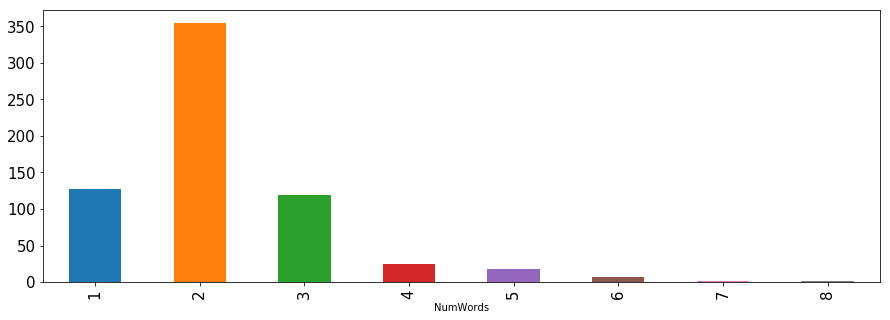

FalseAuthor


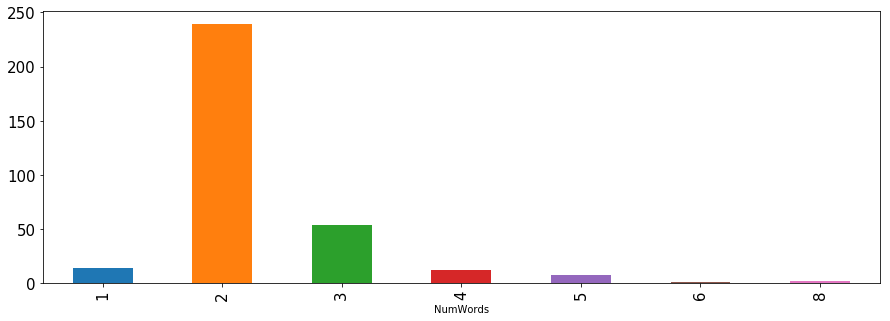

Emotions


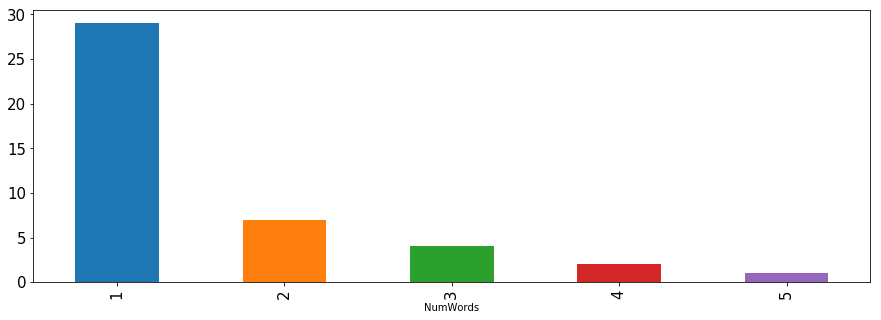

PsychoDisciplines


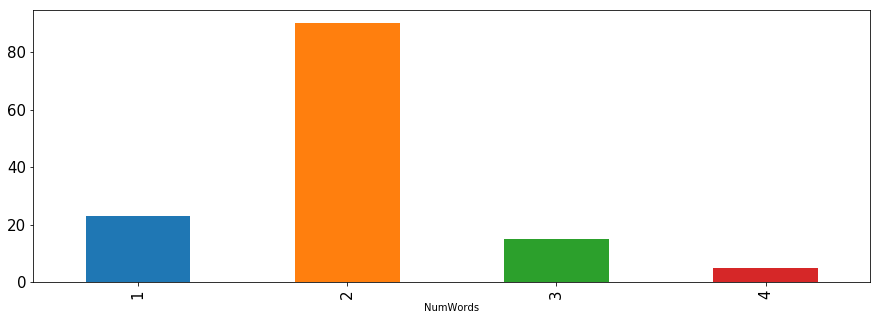

HinduSpace


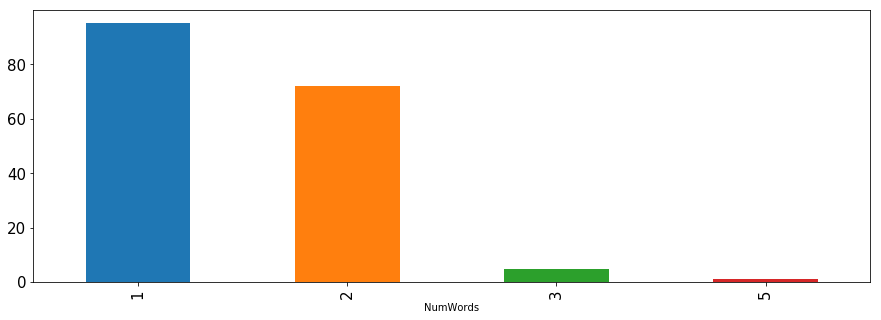

Statistics


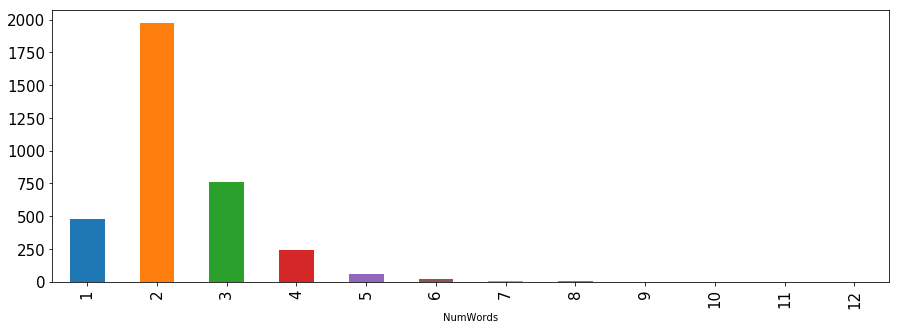

PseudoSciences


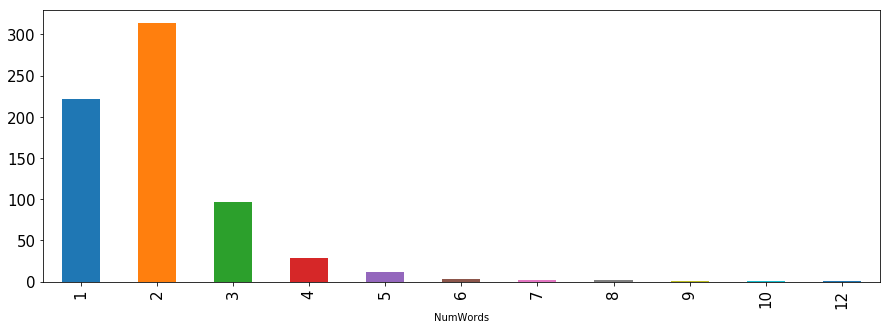

Animans


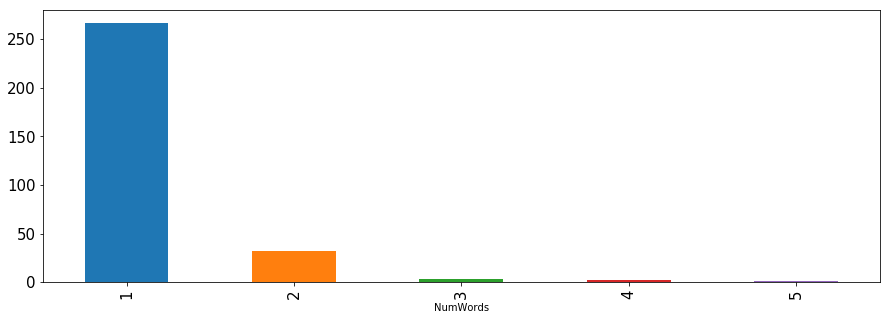

Hobbies


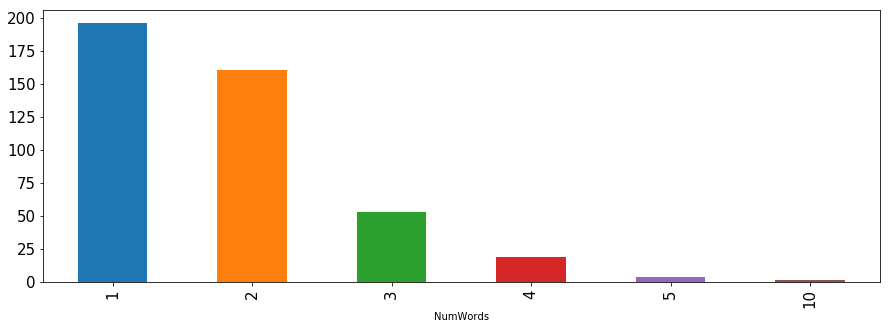

CosmosNames


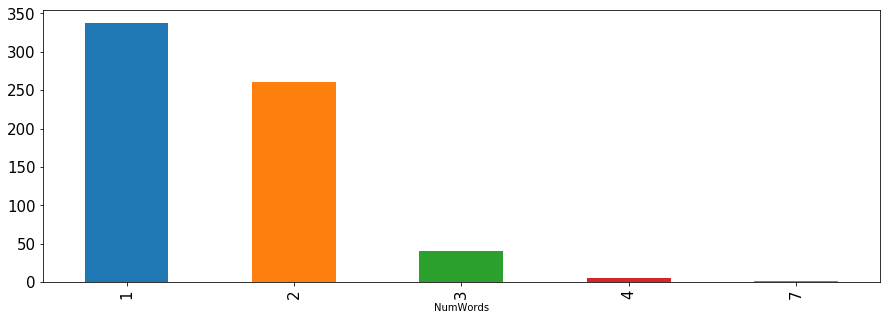

NegDisability


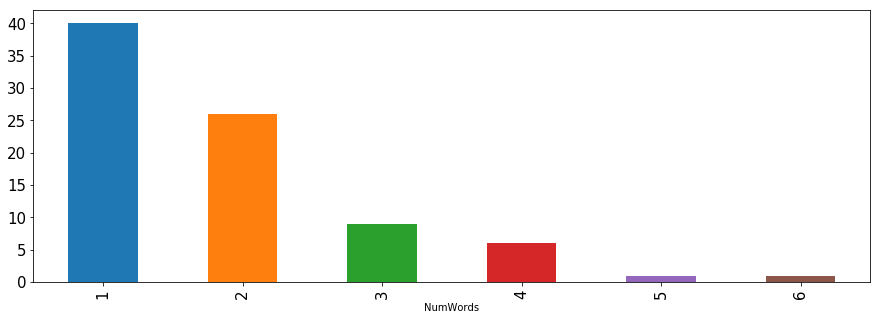

UrbanLegends


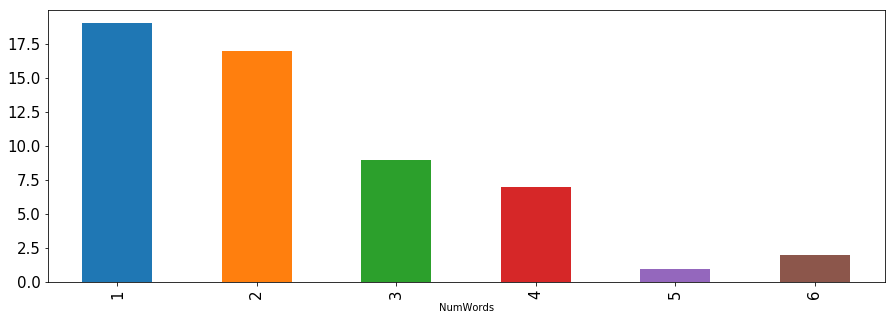

Symbols


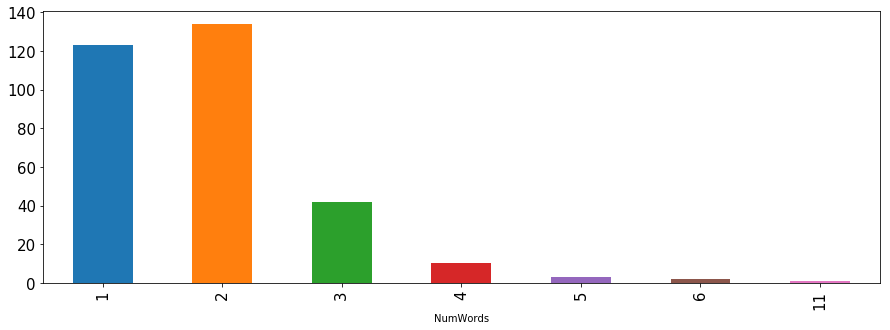

Organisations


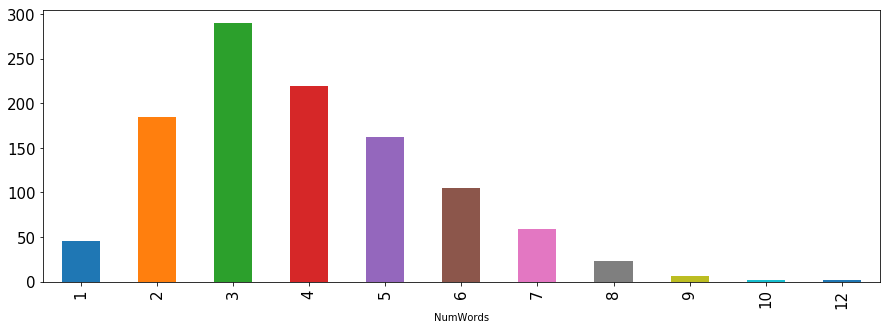

PseudoDiagnoses


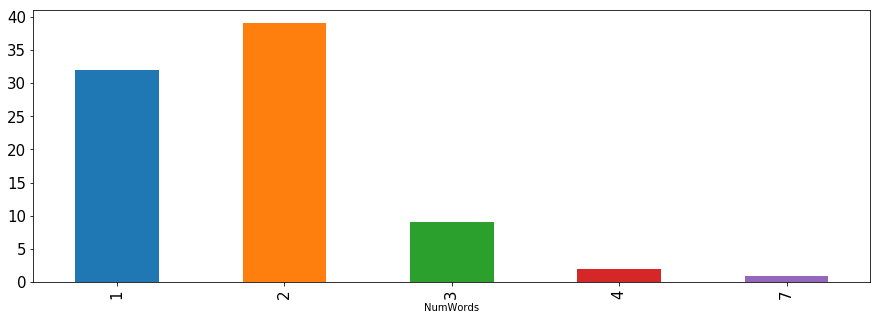

Awards


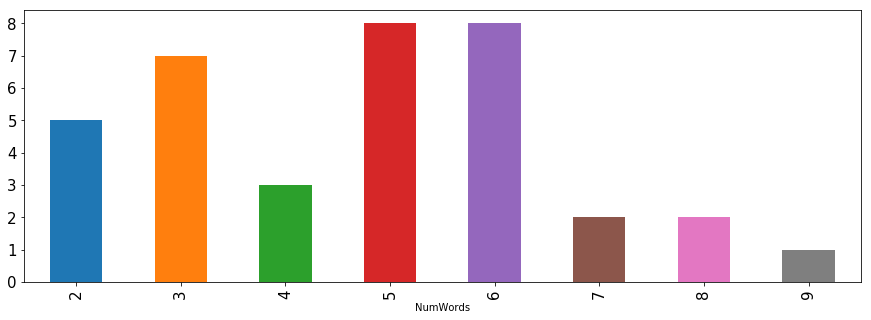

PsychoResearch


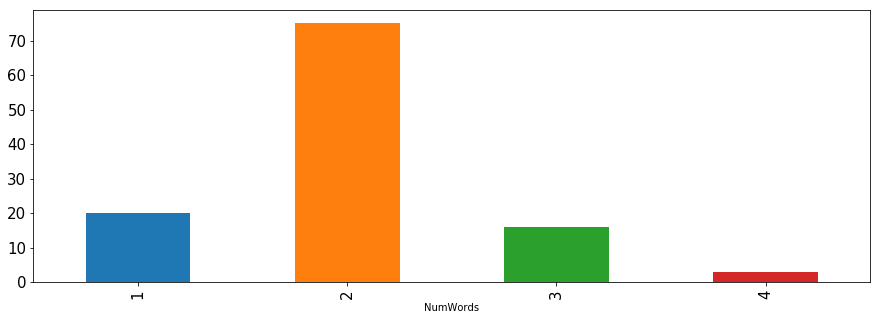

Disorders


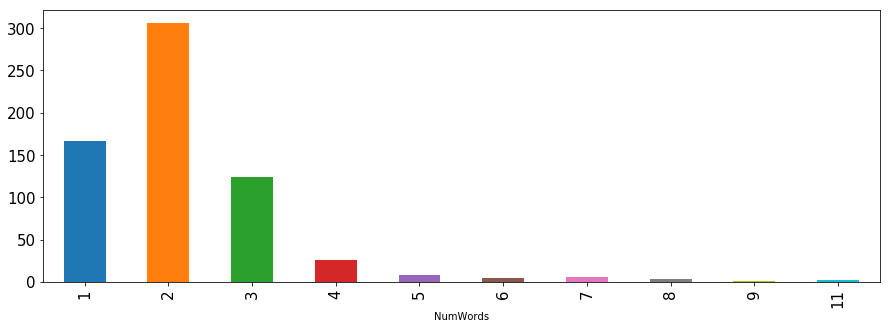

Dances


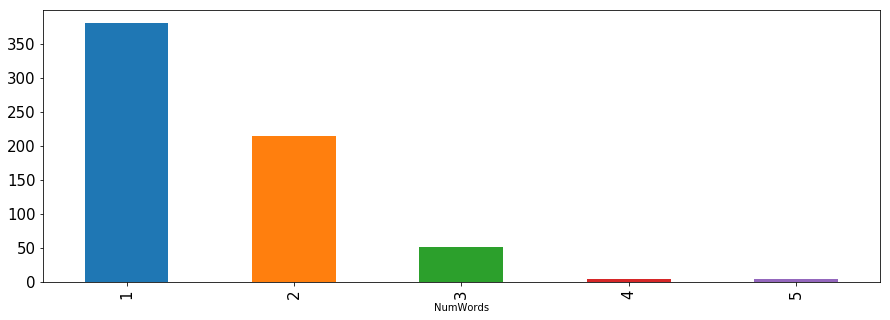

Challanges


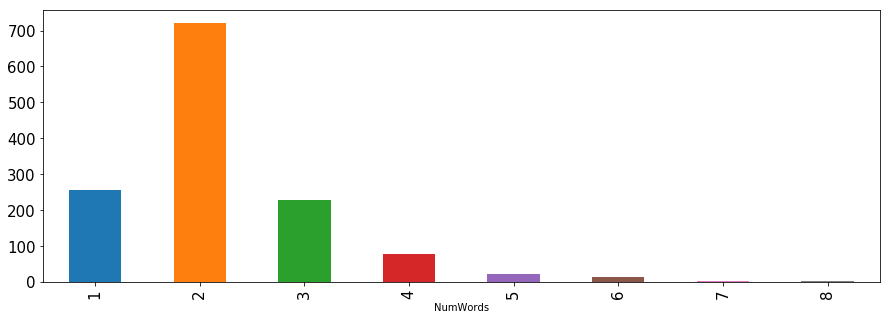

BiblNames


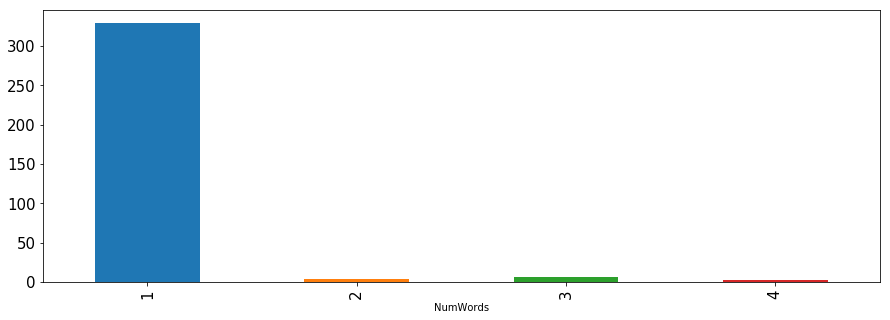

SocialMovements


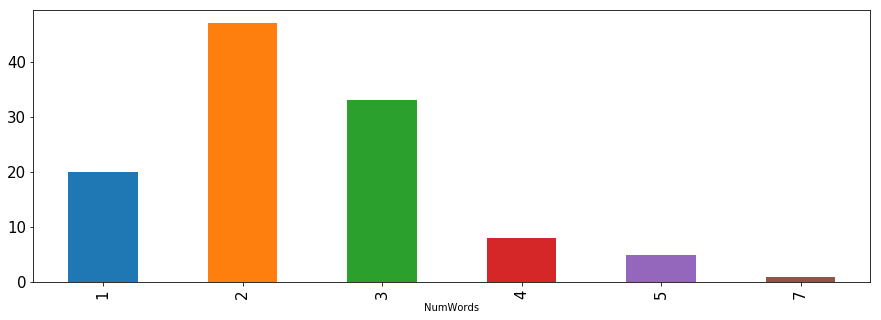

In [1548]:
for cat in phrase_categories:
    pltdata = wiki_ent_fix[(wiki_ent_fix['Category'] == cat)].groupby([wiki_ent_fix.NumWords]).count()['Phrases']
    print(cat)
    # Quick plot
    pltdata.plot(kind='bar', figsize=(15,5), fontsize=15, orientation='vertical')
    plt.show()

In [1575]:

# Final picks for num_words divide (followed with some super dirty accumulative percent calculations)
gr1 = ["BiblNames", "Animals"]
gr12 = ["Emotions", "HinduSpace", "Hobbies", "CosmosNames", "Dances"]
gr123 = ["FalseAuthor", "PsychoResearch", 'PsychoDisciplines', 'Symbols', 'Biases', 'Statistics', 'Disorders', 'Challanges','SocialMovements','PseudoDiagnoses', 'NegDisability', 'UrbanLegends', 'PseudoSciences']
gr123_345_56 = ['Organisations', 'Awards']

to_json_dict = {}
for cat in phrase_categories[:1]:
    # On top of that i will also save all groups without num of words divide
    s = wik.loc[(wik['Category'] == cat) & (wik['NumWords'] <= 2)]['Phrases'].tolist()
    to_json_dict[cat] = s
    if cat in gr1:
        s = wik.loc[(wik['Category'] == cat) & (wik['NumWords'] <= 2)]['Phrases'].tolist()
        to_json_dict[ "".join([cat,"_12"]) ] = s
    elif cat in gr12:
        s = wik.loc[(wik['Category'] == cat) & (wik['NumWords'] <= 2)]['Phrases'].tolist()
        to_json_dict[ "".join([cat,"_12"]) ] = s
        s = wik.loc[(wik['Category'] == cat) & (wik['NumWords'] >= 3)]['Phrases'].tolist()
        to_json_dict["".join([cat,"_3"])] = s
    elif cat in gr123:
        s = wik.loc[(wik['Category'] == cat) & (wik['NumWords'] == 1)]['Phrases'].tolist()
        to_json_dict["".join([cat,"_1"])] = s
        s = wik.loc[(wik['Category'] == cat) & (wik['NumWords'] == 2)]['Phrases'].tolist()
        to_json_dict["".join([cat,"_2"])] = s
        s = wik.loc[(wik['Category'] == cat) & (wik['NumWords'] >= 3)]['Phrases'].tolist()
        to_json_dict["".join([cat,"_3"])] = s
        pass
    elif cat in gr123_345_56:
        s = wik.loc[(wik['Category'] == cat) & (wik['NumWords'] <= 3)]['Phrases'].to_list()
        to_json_dict["".join([cat,"_123"])] = s
        s = wik.loc[(wik['Category'] == cat) & (wik['NumWords'] >= 3) & (wik['NumWords'] <= 5)]['Phrases'].tolist()
        to_json_dict["".join([cat,"_345"])] = s
        s = wik.loc[(wik['Category'] == cat) & (wik['NumWords'] >= 5)]['Phrases'].tolist()
        to_json_dict["".join([cat,"_567"])] = s


In [1576]:
save_path =  CWD + os.path.join(DIR, 'wiki_phrases_clean.json')
with open(save_path, "w") as f:
    json.dump(to_json_dict, f, indent=4)